In [19]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import matplotlib.pyplot as plt


In [20]:
# importar agrupamientos, matriz de distancias y rutas 

df=pd.read_csv('datos/out/lineas_generadas_clusterizadas_ruta_1.csv', index_col=0)
dist_matrix=pd.read_csv('datos/out/matriz_distancias_ruta_1.csv', index_col=0).to_numpy()
rutas = gpd.read_file('datos/concesionado_ruta_shp/Concesionado_Ruta.shp')

In [21]:
# enfoque en ruta 1
ruta_1_ramales=rutas[rutas['RUTA']=="1"]

In [22]:
from shapely import wkt

df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [23]:
# obtener trayectoria representativa por cluster (trayectoria con menor distancia promedio hacia el resto de las trayectorias del mismo cluster)

def trayectoria_representativa(group):
    min_distance_sum = float('inf')
    trayectoria_rep = None
    for i, line1 in enumerate(group.geometry):
        distance_sum = sum(dist_matrix[i][j] for j, line2 in enumerate(group.geometry) if i != j)
        if distance_sum < min_distance_sum:
            min_distance_sum = distance_sum
            trayectoria_rep = line1
    return trayectoria_rep

trayectorias_representativas = gdf.groupby('cluster_id').apply(trayectoria_representativa).reset_index()
trayectorias_representativas.columns = ['cluster_id', 'trayectoria_representativa']

gdf = gdf.merge(trayectorias_representativas, on='cluster_id')

In [24]:
# cosas de geopandas

gdf_unique = gdf.drop_duplicates(subset=['cluster_id', 'trayectoria_representativa'])
gdf_unique = gdf_unique[['cluster_id', 'trayectoria_representativa']]
gdf_unique = gdf_unique.rename(columns={'trayectoria_representativa':'geometry'})

In [25]:
gdf_unique = gpd.GeoDataFrame(gdf_unique, geometry='geometry')

In [26]:
# descartar clusters con menos de 5 trayectorias
cluster_counts = df['cluster_id'].value_counts()
clusters_to_plot = cluster_counts[cluster_counts >= 4].index

gdf_unique = gdf_unique[gdf_unique['cluster_id'].isin(clusters_to_plot)]

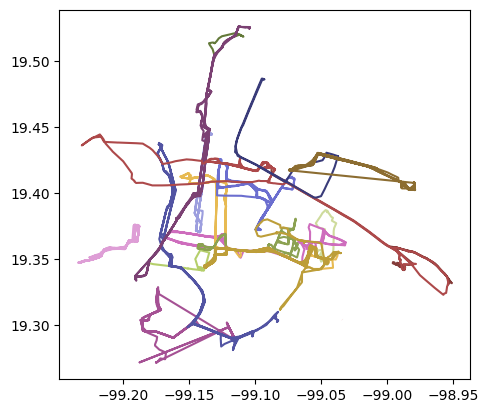

In [27]:
gdf_unique.plot(column="cluster_id", cmap="tab20b")
plt.show()

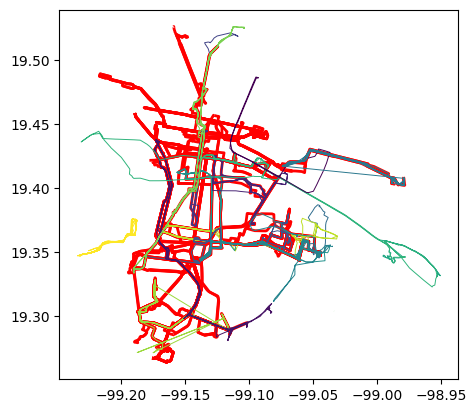

In [28]:
# graficar rutas y trayectorias representativas
fig, ax = plt.subplots()
ruta_1_ramales.plot(color="red", linewidth=2,ax=ax)
gdf_unique.plot(column='cluster_id',linewidth=.7, ax=ax)
plt.show()

In [29]:
import numpy as np

# funcion que regresa las metricas de irregularidad de un cluster basandose en la matriz de distancias

def calcula_irregularidad(group):
    distances = dist_matrix[group.index][:, group.index]
    
    # Calculando las métricas
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    median_distance = np.median(distances)
    q3, q1 = np.percentile(distances, [75, 25])
    iqr = q3 - q1
    coef_var = std_distance / mean_distance if mean_distance != 0 else 0

    return pd.Series({'mean_distance': mean_distance, 'std_distance': std_distance, 'median_distance': median_distance, 'IQR': iqr, 'coef_var': coef_var})

# Aplicando la función a cada cluster
metricas_irregularidad = gdf.groupby('cluster_id').filter(lambda x: len(x) > 4).groupby('cluster_id').apply(calcula_irregularidad).reset_index()


In [30]:
metricas_irregularidad

,cluster_id,mean_distance,std_distance,median_distance,IQR,coef_var
0,0,0.034115,0.041511,0.011233,0.084317,1.216787
1,1,0.061398,0.032833,0.067451,0.039909,0.534760
2,2,0.113823,0.061815,0.128742,0.079021,0.543084
3,3,0.072788,0.047269,0.094429,0.091815,0.649399
4,4,0.097591,0.072303,0.098237,0.141822,0.740877
5,5,0.088859,0.070391,0.065519,0.136340,0.792168
6,6,0.021900,0.035235,0.000071,0.078651,1.608936
7,7,0.095582,0.057884,0.097955,0.077066,0.605598
8,8,0.039155,0.073621,0.008652,0.008903,1.880248
9,9,0.023076,0.027945,0.022003,0.024818,1.210997


In [31]:
# alcaldias
alcaldias = gpd.read_file(r'datos\poligonos_alcaldias_cdmx\poligonos_alcaldias_cdmx.shp')


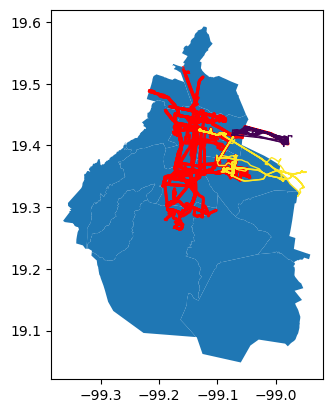

In [32]:
# plottear cluster más irregulares (coeficiente variación)

fig, ax = plt.subplots()
ruta_1_ramales.plot(color="red", linewidth=2,ax=ax)
gdf[gdf['cluster_id'].isin(metricas_irregularidad.sort_values('coef_var', ascending=False).head(2)['cluster_id'])].plot(column='cluster_id',linewidth=1, ax=ax)
alcaldias.plot(ax=ax)
plt.show()
# el analisis se puede continuar exportando las lineas y visualizandolas en QGis, pero es evidente que uno de los clusters es en ciudad Neza
# y el otro en Iztapalapa

In [33]:
gdf[gdf['cluster_id'].isin(metricas_irregularidad.sort_values('coef_var', ascending=False).head(2)['cluster_id'])].to_csv('datos/out/cluster_mas_irregulares.csv')